# Libraries

Only 3 python modules were used.
Numpy is of course used as its mostly written in C and thus is faster than standard Python objects.
Scipy provided the solve_ivp function which will be used to solve the differential equation system.
Finally, Matplotlib was used for graphical rendering.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Empirical data

Initially, values from the Neuronal Dynamic textbook were used (commented values below) but repetitive firing was not observed even with large and long step input currents. Similarly, values for $\alpha$ and $\beta$ functions were obtained in the paperback textbook. After searching the errata on the textbook website, $\alpha_h$ and $\beta_h$ appeared to be wrong. However, even after replacing the values the model didn't behave as expected. I thus obtained another dataset from the neuronaldynamics-exercise website (by the same authors).

In [2]:
#En,Ek,El,gn,gk,gl,C,rest_U = 55,-77,-65,40,35,0.3,1,-65
El = 10.6 #mV
Ek = -12 #mV
En = 115 #mV
gl = 0.3 #msiemens
gk = 36 #msiemens
gn = 120 #msiemens
C = 1 #ufarad
rest_u = 0

n0 = 0.32
m0 = 0.05
h0 = 0.60

data = (En,Ek,El,gn,gk,gl,C)

## Alpha and beta functions
The following functions describes the two parameters $\alpha$ and $\beta$ used to describe the gating variables $m$, $n$ and $h$, in function of membrane potential.

In [3]:
def alpha_n(u):
    return 0.01*(10-u)/(np.exp(1-0.1*u)-1)
def beta_n(u):
    return 0.125*np.exp(-0.0125*u)
def alpha_m(u):
    return 0.1*(25-u)/(np.exp(2.5-0.1*u)-1)
def beta_m(u):
    return 4*np.exp(-0.0556*u)
def alpha_h(u):
    return 0.07*np.exp(-0.05*u)
def beta_h(u):
    return 1/(1+np.exp(3-0.1*u))

# Experimental manipulation

The class below is used to represent the experimental input, i.e. the injection of current in the neuron by the experimenter. The conditions can be modified in order to have various numbers of inputs of set lenght and amplitude.

N.B.: the recurrence with the nested list in the first else of the input_current method is only used to provide the graphical representation of the input (by accepting numpy arrays as inputs).

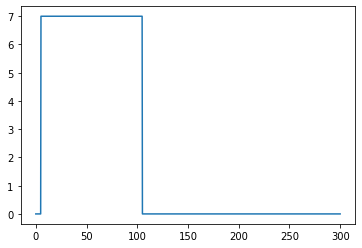

In [4]:
exp_time = 300

class Experiment:
    def __init__(self,start,duration,current):
        self.start = start
        self.duration = duration
        self.current = current
        
    def input_current(self, t):
        s,d,c = self.start,self.duration,self.current
        if type(t) in [np.float64,float,int]:
            for i in range(len(s)):
                if s[i] <= t <= s[i]+d[i]:
                    return c[i]                  
            else: return 0.0
        else: return np.array([self.input_current(i) for i in t])
    
    def plot(self,t):
        plt.plot(t,self.input_current(t))

Experiment([5],[100],[7]).plot(np.linspace(0,exp_time,1000))

The figure above represents a chosen experimental input current.

# Functions

## Differential equations

For convenience, a Membrane class was created. The f function below consists of the system of differential equations described in Part I. Its main method, "experiment", takes experiment duration as an argument and solves the the differential equations (using the default explicit Runge-Kutta method of order 5(4) of the solve_ivp function). The plot function is used to output a graphical representation of the experiment. Finally, an additional 'xp' method can be used to combine the two previous ones for faster testing.

In [5]:
class Membrane:
    def __init__(self,start,duration,current):
        self.u, self.m, self.n, self.h, self.sol = None,None,None,None,None
        self.s = start
        self.d = duration
        self.c = current
    
    def f(self,t,E):
        u,m,n,h = E
        du_dt = (Experiment(self.s,self.d,self.c).input_current(t) - gk*pow(n,4)*(u-Ek) - gn*pow(m,3)*h*(u-En) - gl*(u-El))/C
        dm_dt = alpha_m(u)*(1-m) - beta_m(u)*m
        dn_dt = alpha_n(u)*(1-n) - beta_n(u)*n
        dh_dt = alpha_h(u)*(1-h) - beta_h(u)*h
        return du_dt,dm_dt,dn_dt,dh_dt    
    
    def experiment(self,exp_time):
        self.sol = solve_ivp(self.f,(0.0,exp_time),(rest_u,m0,n0,h0),t_eval=np.linspace(0,exp_time,10000))
        self.u, self.m, self.n, self.h = self.sol.y
        self.t = self.sol.t
        
    def plot(self):
        plt.figure(figsize=(18,10))
        plt.subplot(321)
        plt.plot(self.t,self.u)
        plt.ylabel('Membrane potential (mV)')
        plt.xlabel('Time (ms)')
        plt.plot(self.t,Experiment(self.s,self.d,self.c).input_current(self.t))
        plt.subplot(322)
        plt.plot(self.t,Experiment(self.s,self.d,self.c).input_current(self.t))
        plt.ylabel('Input current (uA/cm2)')
        plt.xlabel('Time (ms)')
        plt.subplot(323)
        plt.plot(self.t,self.m,color="blue")
        plt.plot(self.t,self.n,color="red")
        plt.plot(self.t,self.h,color="green")
        plt.xlabel('Time (ms)')
        plt.subplot(324)
        plt.plot(self.t,self.m,color="blue")
        plt.xlabel('Time (ms)')
        plt.ylabel('m')
        plt.subplot(325)
        plt.plot(self.t,self.n,color="red")
        plt.xlabel('Time (ms)')
        plt.ylabel('n')
        plt.subplot(326)
        plt.plot(self.t,self.h,color="green")
        plt.xlabel('Time (ms)')
        plt.ylabel('h')
    
    def xp(self,exp_time):
        self.experiment(exp_time)
        self.plot()

In [6]:
m = Membrane([50],[150],[7])
m.experiment(300)

<ipython-input-3-cf1a95915007>:6: RuntimeWarning: overflow encountered in exp
  return 0.1*(25-u)/(np.exp(2.5-0.1*u)-1)
<ipython-input-3-cf1a95915007>:8: RuntimeWarning: overflow encountered in exp
  return 4*np.exp(-0.0556*u)
<ipython-input-3-cf1a95915007>:2: RuntimeWarning: overflow encountered in exp
  return 0.01*(10-u)/(np.exp(1-0.1*u)-1)
<ipython-input-3-cf1a95915007>:4: RuntimeWarning: overflow encountered in exp
  return 0.125*np.exp(-0.0125*u)
<ipython-input-3-cf1a95915007>:10: RuntimeWarning: overflow encountered in exp
  return 0.07*np.exp(-0.05*u)
<ipython-input-3-cf1a95915007>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(3-0.1*u))


# Results

## Long step current
On the figures below we can observe the influence of a long (100 ms) step current. There is repetitive firing during the current input period. This dynamic corresponds roughly to the behaviour of actual neurons. After each spike we can observe a small hyperpolarization, corresponding to the slower dynamic of $n$ and $h$ which respectively favors potassium ion movements and limits sodium ion movements.

NB: it should be noted that overflow errors resulting from exponentials in $\alpha$ and $\beta$ functions causing some values to have a nearlly null denominator may affect the results.

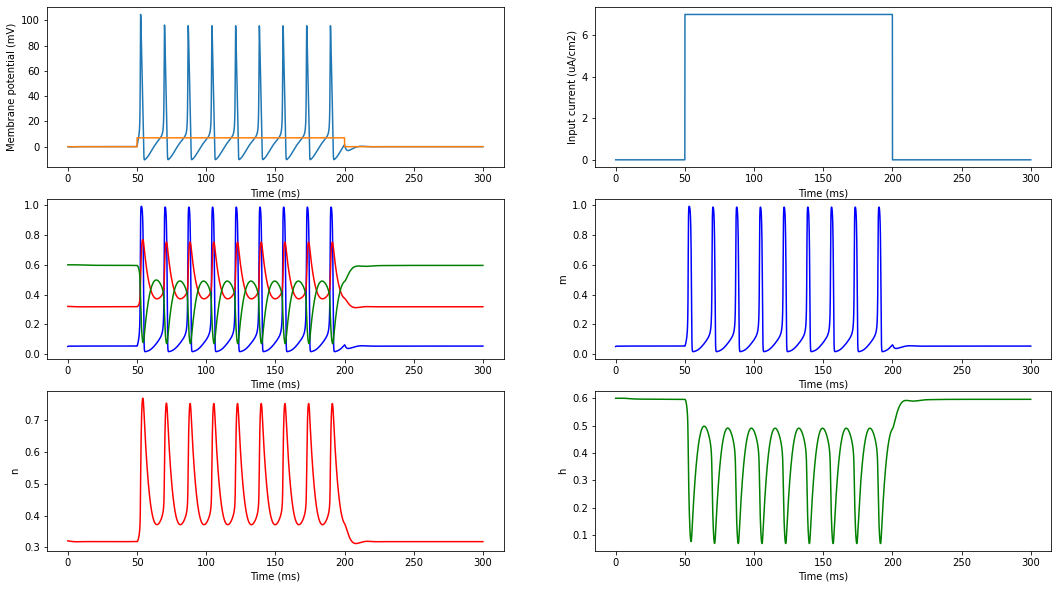

In [7]:
m.plot()

## Short pulses

In [8]:
m2 = Membrane([5,15,50,60],[5,5,5,5],[7,7,7,9])
m2.experiment(200)

<ipython-input-5-8724e02d8045>:10: RuntimeWarning: overflow encountered in double_scalars
  du_dt = (Experiment(self.s,self.d,self.c).input_current(t) - gk*pow(n,4)*(u-Ek) - gn*pow(m,3)*h*(u-En) - gl*(u-El))/C
<ipython-input-3-cf1a95915007>:6: RuntimeWarning: overflow encountered in exp
  return 0.1*(25-u)/(np.exp(2.5-0.1*u)-1)
<ipython-input-3-cf1a95915007>:8: RuntimeWarning: overflow encountered in exp
  return 4*np.exp(-0.0556*u)
<ipython-input-3-cf1a95915007>:2: RuntimeWarning: overflow encountered in exp
  return 0.01*(10-u)/(np.exp(1-0.1*u)-1)
<ipython-input-3-cf1a95915007>:10: RuntimeWarning: overflow encountered in exp
  return 0.07*np.exp(-0.05*u)
<ipython-input-3-cf1a95915007>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(3-0.1*u))
<ipython-input-3-cf1a95915007>:4: RuntimeWarning: overflow encountered in exp
  return 0.125*np.exp(-0.0125*u)


On the figures below, we can observe the influence of short current pulses on the membrane potential. It is interesting to observe that, even if all the pulses were of similar lenght and duration, the second pulse failed to initiate a spike, as it landed during the refractory period. On the other hand, pulse number 4 successfully generated a spike. In that case, the pulse interval was identical, but the intensity was higher (9 uA/cm2 instead of 7).

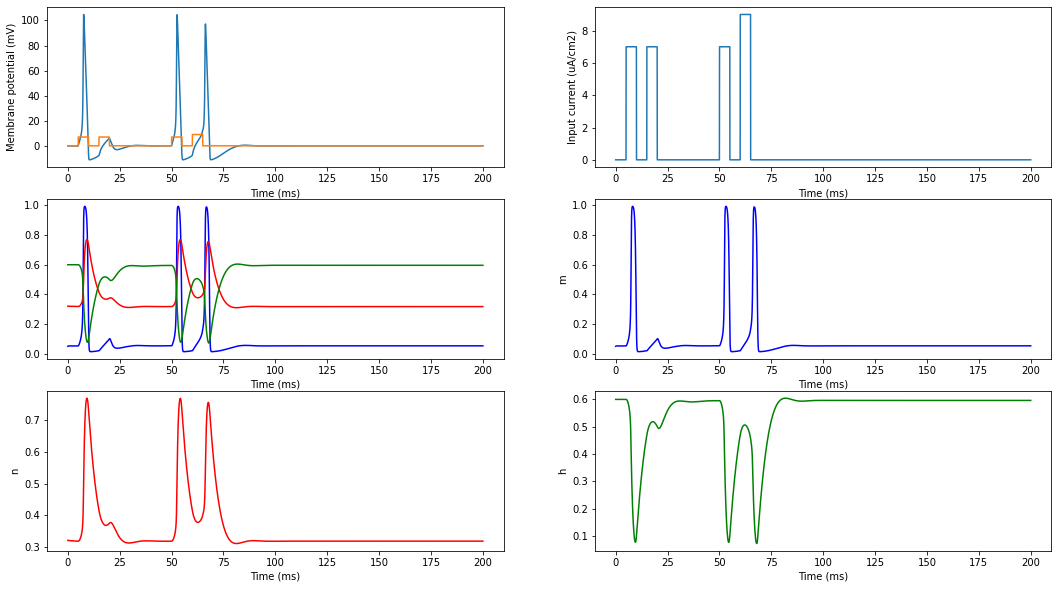

In [9]:
m2.plot()

# Gain function
If we consider again a step current and we analyze the firing frequency of the neuron for n different experiments with increasing current input, we can obtain an approximation of the gain function of the model.

The code below creates 100 experiments with increasing input (from 0 to 20 uA/cm2) applied during the same duration (1000 ms) and determinates the firing frequency (by simply calculating the number of peaks).

In [10]:
intensities = np.linspace(0,20,100)
frequencies = np.array([0]*len(intensities))

for i in range(len(intensities)):
    M = Membrane([5],[1000],[intensities[i]])
    M.experiment(1010)
    test = M.u - max(M.u)/2
    test[test > 0] = 100
    test[test < 0] = 0
    test2 = np.diff(test)
    test3 = test2[test2 <0]
    frequencies[i] = len(test3)

<ipython-input-3-cf1a95915007>:6: RuntimeWarning: overflow encountered in exp
  return 0.1*(25-u)/(np.exp(2.5-0.1*u)-1)
<ipython-input-3-cf1a95915007>:8: RuntimeWarning: overflow encountered in exp
  return 4*np.exp(-0.0556*u)
<ipython-input-3-cf1a95915007>:2: RuntimeWarning: overflow encountered in exp
  return 0.01*(10-u)/(np.exp(1-0.1*u)-1)
<ipython-input-3-cf1a95915007>:4: RuntimeWarning: overflow encountered in exp
  return 0.125*np.exp(-0.0125*u)
<ipython-input-3-cf1a95915007>:10: RuntimeWarning: overflow encountered in exp
  return 0.07*np.exp(-0.05*u)
<ipython-input-3-cf1a95915007>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(3-0.1*u))
<ipython-input-5-8724e02d8045>:10: RuntimeWarning: overflow encountered in double_scalars
  du_dt = (Experiment(self.s,self.d,self.c).input_current(t) - gk*pow(n,4)*(u-Ek) - gn*pow(m,3)*h*(u-En) - gl*(u-El))/C
<ipython-input-5-8724e02d8045>:11: RuntimeWarning: invalid value encountered in double_scalars
  dm_dt = alpha_m(u

The figure below shows a graphical representation of the gain function. As we clearly see a jump at the treshold (around 6 uA/cm2) where the frequency immediately starts at around 50, we can say that the neurons modelled are of type II.

Text(0.5, 0, 'Frequency (Hz)')

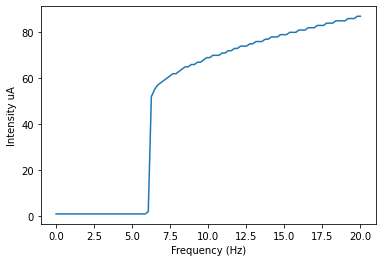

In [11]:
plt.plot(intensities,frequencies)
plt.ylabel('Intensity uA')
plt.xlabel('Frequency (Hz)')